<a href="https://colab.research.google.com/github/DrKenReid/Generalized-Analysis-of-Text-Data/blob/main/Generalized_Analysis_of_Text_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generalized Analysis of Text Data

Written by [Ken Reid](https://github.com/DrKenReid).

## Intro

We will explore various techniques for analyzing text data regardless of context. The workflow is designed to inspire other projects, or to be a reference guide for certain techniques. The goal is to leverage AI to gain deeper insights from textual data, such as identifying themes, detecting sentiment, and recognizing named entities.

To run this notebook, click "Runtime" in the menu at the top, then select "Run all".

##Table of Contents

1. Setup
2. Data Collection
3. Dataset Building
4. Initial Textual Analysis
5. Exploratory Data Analysis
6. AI-Enhanced Insights

  6.1 Topic Modeling

  6.2 Text Clustering

  6.3 Word Embeddings

  6.4 Document Similarity

  6.5 Named Entity Recognition

  6.6 Topic Network Visualization

  6.7 Sentiment Analysis

  6.8 Text Classification

  6.9 Text Summarization
  
  6.10 Part-of-Speech (POS) Tagging

  6.11 Dependency Parsing

  6.12 Topic Coherence

Conclusion and Next Steps


## 1. Setup

First, let's import the necessary libraries. These libraries provide the tools we need for data manipulation, analysis, and visualization:

In [24]:
# Importing essential libraries for data handling and analysis
import pandas as pd   # For data manipulation and analysis
import numpy as np    # For numerical operations
import matplotlib.pyplot as plt  # For creating visualizations
import seaborn as sns  # For statistical data visualization

# Importing libraries specifically for textual data processing and AI techniques
import nltk  # Natural Language Toolkit, useful for text processing
from nltk.corpus import stopwords  # For filtering out common words
from nltk.tokenize import word_tokenize  # For splitting text into words
from nltk.stem import WordNetLemmatizer  # For reducing words to their base form
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # For sentiment analysis
import spacy  # For advanced NLP tasks like Named Entity Recognition
from textblob import TextBlob  # For sentiment analysis and other NLP tasks

# Machine Learning libraries
from sklearn.datasets import fetch_20newsgroups  # For fetching the 20 Newsgroups dataset
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # For converting text to numerical data
from sklearn.decomposition import LatentDirichletAllocation, PCA  # For topic modeling and dimensionality reduction
from sklearn.cluster import KMeans  # For text clustering
from sklearn.manifold import TSNE  # For visualizing high-dimensional data
from sklearn.metrics.pairwise import cosine_similarity  # For document similarity
from sklearn.model_selection import train_test_split  # For splitting data into training and testing sets
from sklearn.linear_model import LogisticRegression  # For text classification
from sklearn.metrics import accuracy_score, classification_report  # For evaluating classification models

# Word Embeddings
from gensim.models import Word2Vec  # For creating word embeddings

# Network Analysis
import networkx as nx  # For creating network visualizations

# Text Summarization
from transformers import pipeline  # For text summarization using pre-trained models

# Topic Coherence
from gensim.corpora import Dictionary  # For creating a dictionary representation of a corpus
from gensim.models.coherencemodel import CoherenceModel  # For calculating topic coherence

# Other utilities
from typing import List, Tuple, Dict  # For type hinting
from collections import Counter, defaultdict  # For counting and creating default dictionaries
import re  # For regular expressions

# Ensure the necessary resources for NLTK are downloaded
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

import requests

# Fetch additional stopwords
url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-en/master/stopwords-en.txt"
response = requests.get(url)
additional_stopwords = set(response.text.split())

# Combine NLTK stopwords with additional stopwords
stop_words = set(stopwords.words('english')).union(additional_stopwords)

# Load the spaCy model for English
nlp = spacy.load("en_core_web_sm")

# Set visualization styles
sns.set(style="whitegrid")

# Install required libraries
!pip install pandas numpy matplotlib seaborn nltk spacy textblob scikit-learn gensim networkx transformers > /dev/null 2>&1 || echo "Error occurred during installation"

# Download the English language model for spaCy
!python -m spacy download en_core_web_sm > /dev/null 2>&1 || echo "Error occurred during download"

print("Initialization completed.")

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Initialization completed.


## 2. Data Collection

In this section, we'll use the 20 Newsgroups dataset, a popular dataset for text classification tasks in machine learning. This dataset contains approximately 20,000 newsgroup documents, organized into 20 categories.

In [25]:
def collect_data(categories: List[str] = None) -> Tuple[List[str], List[int], List[str]]:
    """
    Fetch data from the 20 Newsgroups dataset.

    Args:
        categories (List[str], optional): List of categories to fetch. If None, all categories are fetched.
            Default is a selection of four categories.

    Returns:
        Tuple[List[str], List[int], List[str]]: A tuple containing the list of documents,
                                                their corresponding category indices,
                                                and the category names.
    """
    if categories is None:
        categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']

    # Fetch the dataset
    newsgroups = fetch_20newsgroups(subset='all', categories=categories, remove=('headers', 'footers', 'quotes'))

    # Return the data, target labels, and target names
    return newsgroups.data, newsgroups.target, newsgroups.target_names

# Collect data
documents, categories, category_names = collect_data()
print(f"Collected {len(documents)} documents across {len(category_names)} categories.")
print(f"Categories: {', '.join(category_names)}")
print("Data collection complete.")


Collected 3387 documents across 4 categories.
Categories: alt.atheism, comp.graphics, sci.space, talk.religion.misc
Data collection complete.


## 3. Dataset Building

Now that we have our raw data, let's build a structured dataset using pandas. This will help us organize the text documents along with their metadata for easier analysis.


In [26]:
import pandas as pd  # Import pandas for data manipulation

def build_dataset(documents: List[str], categories: List[int], category_names: List[str]) -> pd.DataFrame:
    """
    Build a pandas DataFrame from the collected documents.

    Args:
        documents (List[str]): List of text documents.
        categories (List[int]): List of category indices for each document.
        category_names (List[str]): List of category names.

    Returns:
        pd.DataFrame: A DataFrame containing the documents and their metadata.
    """
    # Create a DataFrame with the text, category names, document length, and word count
    df = pd.DataFrame({
        'text': documents,
        'category': [category_names[cat] for cat in categories],
        'length': [len(doc) for doc in documents],
        'word_count': [len(doc.split()) for doc in documents]
    })
    return df

# Build the dataset
df = build_dataset(documents, categories, category_names)
print("*************Example of the data:*************")
print(df.head())  # Display the first few rows of the DataFrame
print("\n*************Shape of the data:*************")
print(f"\nDataset shape: {df.shape}")  # Print the shape of the DataFrame
print("\n*************Category distribution of the data:*************")
print(f"\nCategory distribution:\n{df['category'].value_counts()}")  # Print the distribution of categories
print("\n*************Summary statistics of the data:*************")
print(f"\nSummary statistics:\n{df.describe()}")  # Print summary statistics
print("\n\nDataset building complete.")

*************Example of the data:*************
                                                text            category  \
0  My point is that you set up your views as the ...         alt.atheism   
1  \nBy '8 grey level images' you mean 8 items of...       comp.graphics   
2  FIRST ANNUAL PHIGS USER GROUP CONFERENCE\n\n  ...       comp.graphics   
3  I responded to Jim's other articles today, but...  talk.religion.misc   
4  \nWell, I am placing a file at my ftp today th...       comp.graphics   

   length  word_count  
0     625         111  
1     580         108  
2    7748         882  
3    1991         337  
4     730         118  

*************Shape of the data:*************

Dataset shape: (3387, 4)

*************Category distribution of the data:*************

Category distribution:
category
sci.space             987
comp.graphics         973
alt.atheism           799
talk.religion.misc    628
Name: count, dtype: int64

*************Summary statistics of the data:**********

## 4. Initial Textual Analysis

Let's perform some initial analysis on our text data, including word frequency and basic statistics. This will help us understand the common words used and some basic characteristics of our dataset.

In [27]:
def analyze_text(df: pd.DataFrame) -> Tuple[Counter, Dict[str, float]]:
    """
    Perform initial textual analysis on the dataset.

    Args:
        df (pd.DataFrame): The dataset containing text documents.

    Returns:
        Tuple[Counter, Dict[str, float]]: A tuple containing word frequency counter and text statistics.
    """
    # Combine all text documents into one large text
    all_text = ' '.join(df['text'])

    # Tokenize text and filter out stopwords, non-alphanumeric words, and integers
    words = [word.lower() for word in word_tokenize(all_text)
             if word.isalnum() and word.lower() not in stop_words and not word.isdigit()]

    # Count the frequency of each word
    word_freq = Counter(words)

    # Calculate basic statistics of the dataset
    stats = {
        'avg_document_length': df['length'].mean(),  # Average length of documents
        'avg_word_count': df['word_count'].mean(),   # Average word count per document
        'unique_words': len(set(words))              # Number of unique words in the dataset
    }

    return word_freq, stats

# Perform initial analysis
word_freq, text_stats = analyze_text(df)

# Display the results
print("Top 10 most common words, excluding stopwords:")
print(word_freq.most_common(10))
print("\nText statistics:")
for key, value in text_stats.items():
    print(f"{key}: {value:.2f}")

Top 10 most common words, excluding stopwords:
[('god', 1257), ('people', 1244), ('space', 1235), ('image', 1190), ('time', 867), ('data', 725), ('jpeg', 696), ('file', 647), ('jesus', 632), ('program', 629)]

Text statistics:
avg_document_length: 1248.16
avg_word_count: 199.50
unique_words: 28006.00


## 5. Exploratory Data Analysis

Let's visualize some of our findings to gain insights into our data. We'll use a colorblind-friendly palette and modern Seaborn styling.


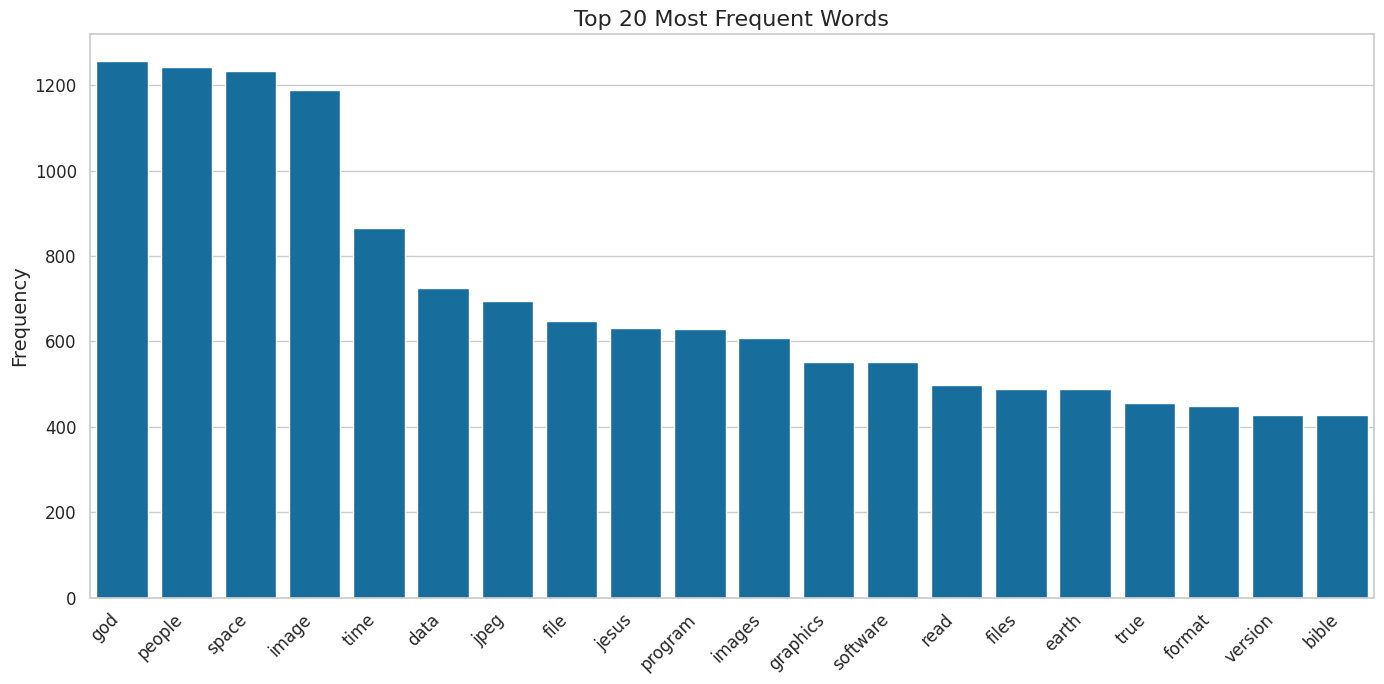

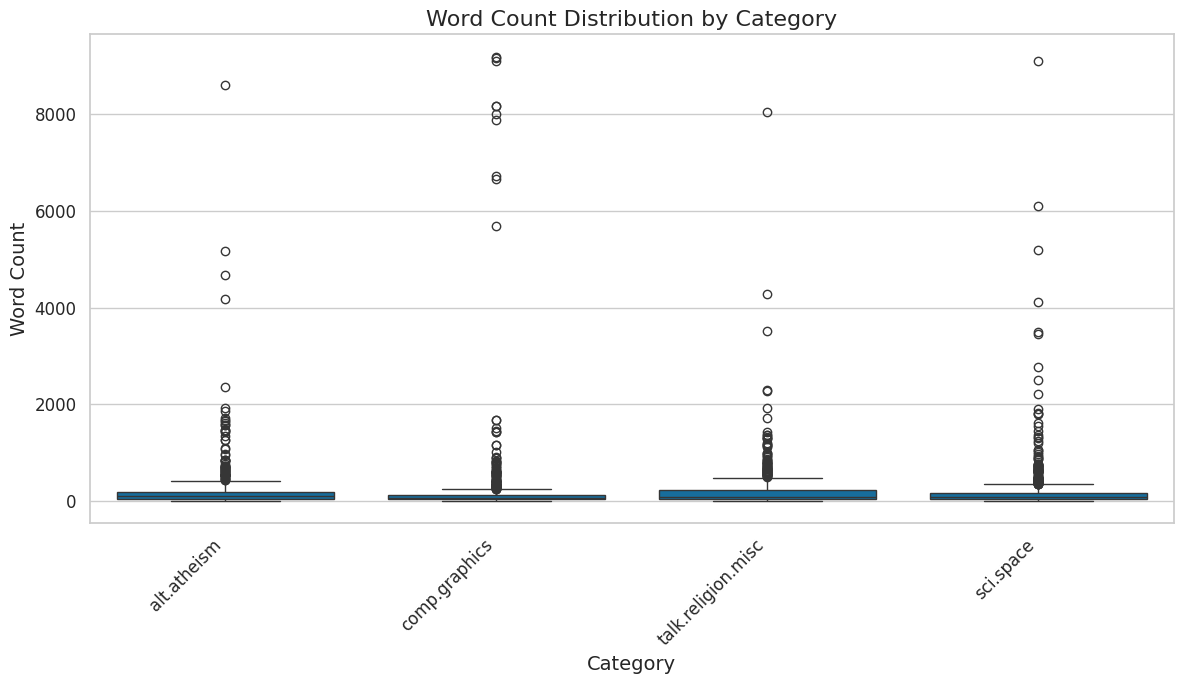

In [28]:
def set_plot_style():
    """
    Set up the plotting style for better visuals and colorblind-friendliness.
    """
    # Use a colorblind-friendly palette
    colors = ['#0173B2', '#DE8F05', '#029E73', '#D55E00', '#CC78BC', '#CA9161', '#FBAFE4', '#949494', '#ECE133', '#56B4E9']
    sns.set_palette(sns.color_palette(colors))

    # Set the style to a cleaner, more modern look
    sns.set_style("whitegrid")

    # Increase font sizes for better readability
    plt.rcParams['font.size'] = 12
    plt.rcParams['axes.labelsize'] = 14
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize'] = 12
    plt.rcParams['ytick.labelsize'] = 12

def visualize_data(df: pd.DataFrame, word_freq: Counter):
    """
    Create visualizations for exploratory data analysis.

    Args:
        df (pd.DataFrame): The dataset containing text documents and their metadata.
        word_freq (Counter): Word frequency counter from the initial textual analysis.
    """
    # Apply the plotting style
    set_plot_style()

    # Plot 1: Word frequency distribution
    plt.figure(figsize=(14, 7))
    words, counts = zip(*word_freq.most_common(20))
    sns.barplot(x=list(words), y=list(counts), color=sns.color_palette()[0])
    plt.title('Top 20 Most Frequent Words')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

    # Plot 2: Word count distribution by category
    plt.figure(figsize=(12, 7))
    sns.boxplot(x='category', y='word_count', data=df)
    plt.title('Word Count Distribution by Category')
    plt.xlabel('Category')
    plt.ylabel('Word Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create visualizations
visualize_data(df, word_freq)


## 6. AI-Enhanced Insights

In this section, we'll explore various techniques that can be loosely categorized as "AI", in order to gain deeper insights into our textual data. These methods can help uncover patterns, themes, and relationships that might not be immediately apparent through traditional analysis.


### 6.1 Topic Modeling

This cell performs topic modeling on our dataset and provides two visualizations:

1. Bar plots showing the top words for each identified topic.
2. An area plot showing the distribution of topics across the first 100 documents in the dataset.

These visualizations aid in understanding the main themes in text data and how these themes are distributed across documents.


Topics and their top words:
Topic 1: space, like, thanks, know, graphics, program, just, use, does, image
Topic 2: mary, just, mormon, mormons, shafer, dryden, 3do, perfect, insisting, balls
Topic 3: turkey, christmas, deleted, hausmann, leftover, truelove, maddi, served, caste, bbs
Topic 4: somebody, batf, deletion, fbi, dobbs, tea, ye, compromise, bob, meet
Topic 5: oort, mozumder, smiley, cl, hm, tommy, 336, 517, mcwilliams, 9591
Topic 6: god, people, don, think, say, jesus, just, religion, believe, does


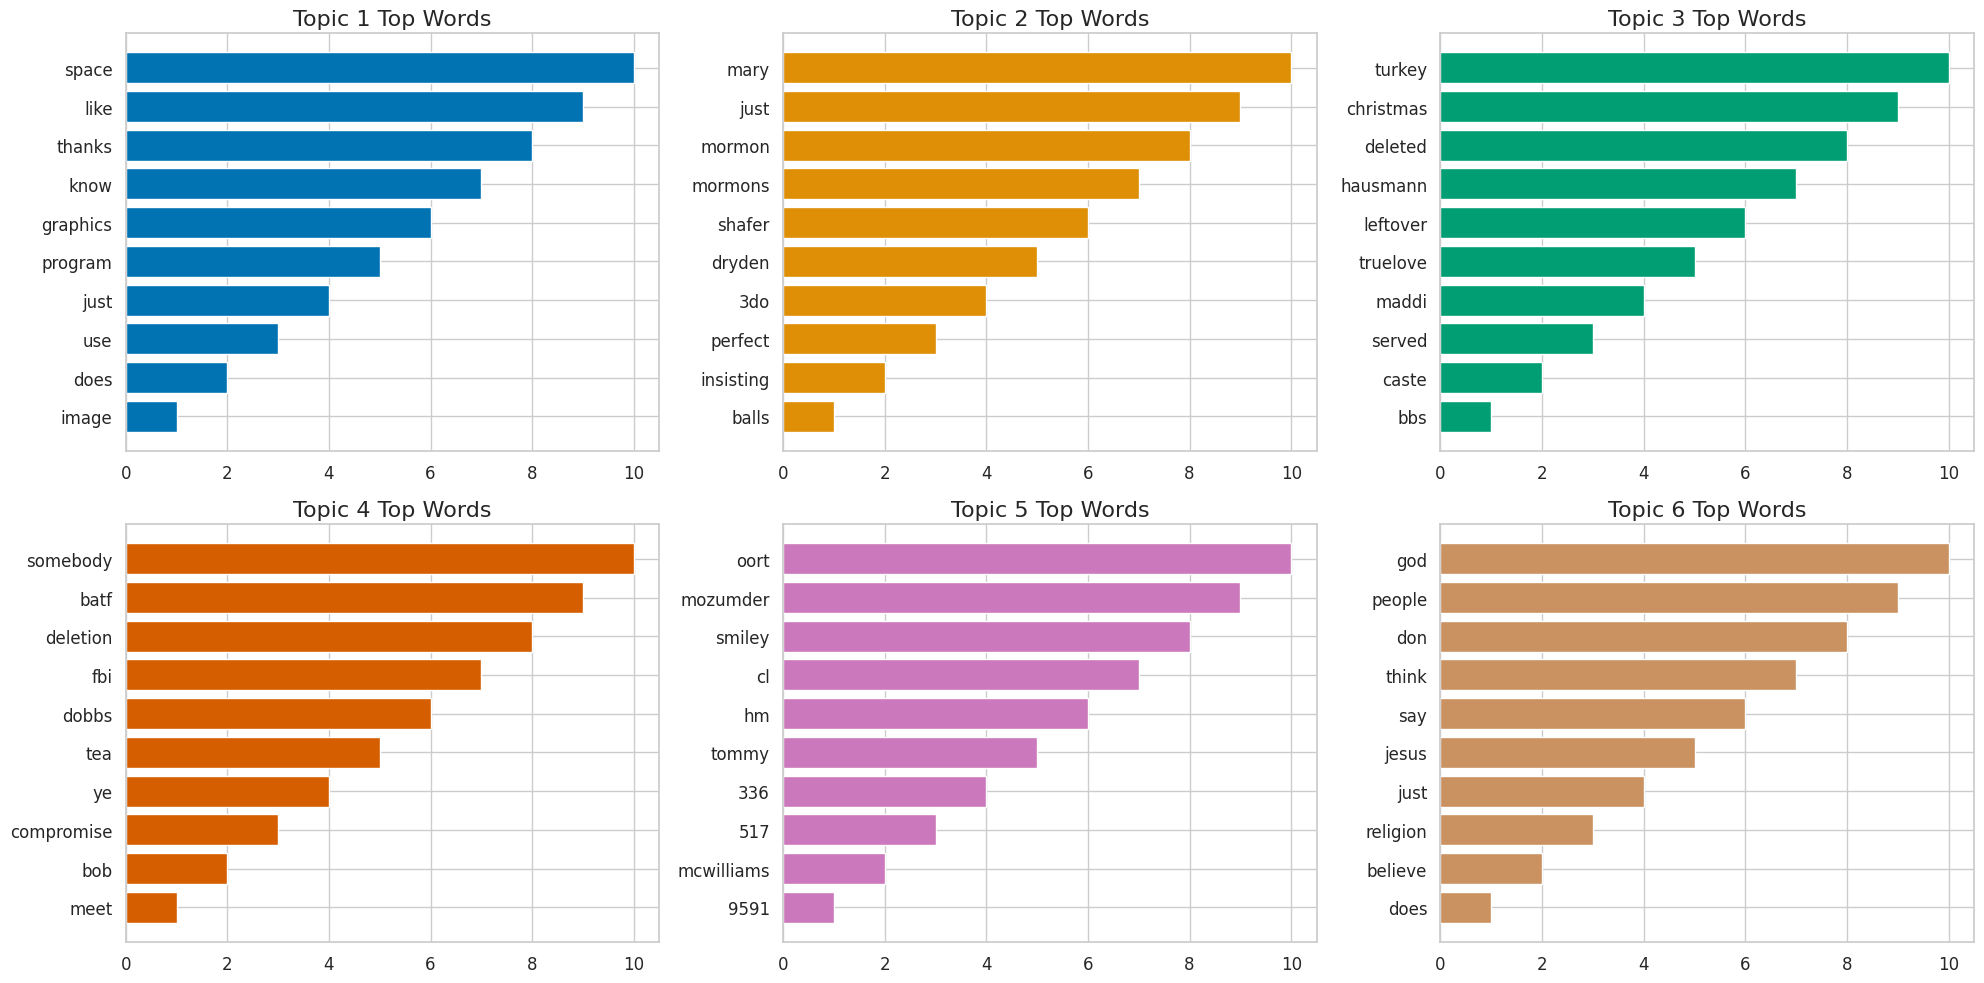

<Figure size 1200x600 with 0 Axes>

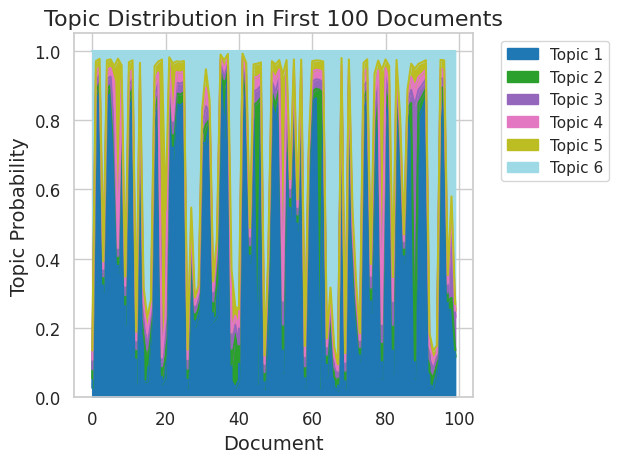

In [29]:
def perform_topic_modeling(df: pd.DataFrame, num_topics: int = 6) -> Tuple[List[List[str]], List[List[float]]]:
    """
    Perform topic modeling using Latent Dirichlet Allocation (LDA).

    Args:
        df (pd.DataFrame): The dataset containing text documents.
        num_topics (int): Number of topics to extract.

    Returns:
        Tuple[List[List[str]], List[List[float]]]: A tuple containing the top words for each topic
        and the topic distribution for each document.
    """
    # Convert text documents to a TF-IDF matrix
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['text'])

    # Fit the LDA model
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix)

    # Extract the top words for each topic
    feature_names = vectorizer.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-11:-1]  # Get indices of top words for the topic
        top_words.append([feature_names[i] for i in top_words_idx])

    # Calculate the topic distribution for each document
    doc_topic_dist = lda.transform(tfidf_matrix)

    return top_words, doc_topic_dist.tolist()

# Perform topic modeling
top_words, doc_topic_dist = perform_topic_modeling(df)

# Print topics and their top words
print("Topics and their top words:")
for i, topic_words in enumerate(top_words):
    print(f"Topic {i+1}: {', '.join(topic_words)}")

# Visualize top words for each topic
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
axes = axes.flatten()

for i, (topic_words, ax) in enumerate(zip(top_words, axes)):
    words = topic_words[:10]  # Take top 10 words
    word_importance = range(len(words), 0, -1)  # Assign importance based on order
    ax.barh(words, word_importance, color=sns.color_palette()[i % len(sns.color_palette())])
    ax.set_title(f'Topic {i+1} Top Words')
    ax.invert_yaxis()  # Invert y-axis to show most important words on top

plt.tight_layout()
plt.show()

# Visualize topic distribution across documents
topic_names = [f'Topic {i+1}' for i in range(len(top_words))]
doc_topic_df = pd.DataFrame(doc_topic_dist, columns=topic_names)

plt.figure(figsize=(12, 6))
doc_topic_df.iloc[:100].plot(kind='area', stacked=True, colormap='tab20')
plt.title('Topic Distribution in First 100 Documents')
plt.xlabel('Document')
plt.ylabel('Topic Probability')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


### 6.2 Text Clustering

Clustering is a powerful technique that allows us to group similar documents together based on their content. This can reveal hidden patterns and themes within large collections of text, providing insights into how different topics or sentiments are distributed across the data.

Cluster distribution:
cluster
0     429
1     660
2     223
3     485
4    1590
Name: count, dtype: int64


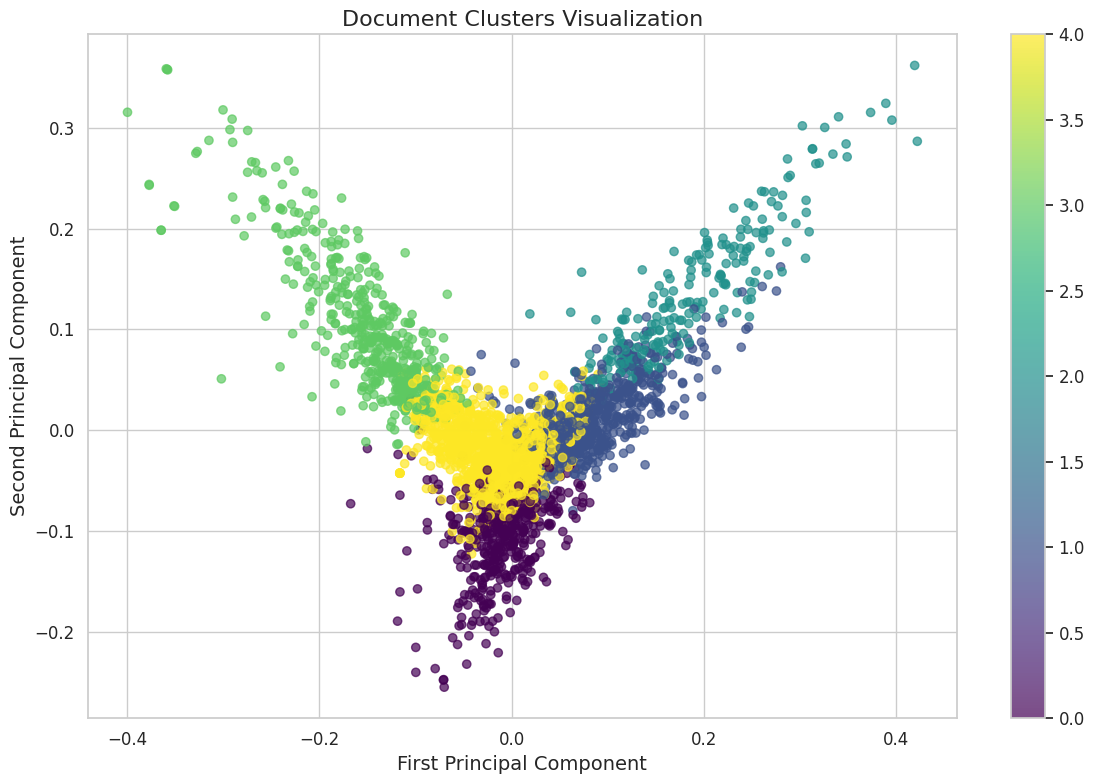


Top words in Cluster 0:
earth, launch, like, mission, nasa, orbit, satellite, space, time, year

Top words in Cluster 1:
dont, know, like, make, people, right, say, think, time, way

Top words in Cluster 2:
atheist, belief, believe, bible, christian, god, jehovah, jesus, people, say

Top words in Cluster 3:
available, bit, color, data, file, format, graphic, image, jpeg, program

Top words in Cluster 4:
computer, dont, know, like, line, point, problem, software, time, use


In [30]:
def preprocess_text(text: str) -> str:
    """
    Preprocess the input text by converting to lowercase, removing special characters,
    tokenizing, removing stopwords, and lemmatizing.

    Args:
        text (str): The input text document.

    Returns:
        str: The preprocessed text.
    """
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters and numbers
    tokens = word_tokenize(text)  # Tokenize
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]  # Remove stopwords and short words
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatize
    return ' '.join(tokens)

def perform_text_clustering(df: pd.DataFrame, n_clusters: int = 5) -> Tuple[List[int], np.ndarray]:
    """
    Perform text clustering using K-means.

    Args:
        df (pd.DataFrame): The dataset containing text documents.
        n_clusters (int): Number of clusters to create.

    Returns:
        Tuple[List[int], np.ndarray]: Cluster assignments for each document and the TF-IDF matrix.
    """
    df['processed_text'] = df['text'].apply(preprocess_text)  # Preprocess the text

    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['processed_text'])  # Create TF-IDF matrix

    kmeans = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)  # Initialize KMeans
    cluster_assignments = kmeans.fit_predict(tfidf_matrix)  # Fit KMeans and get cluster assignments

    return cluster_assignments.tolist(), tfidf_matrix

# Perform text clustering
cluster_assignments, tfidf_matrix = perform_text_clustering(df)
df['cluster'] = cluster_assignments  # Add cluster assignments to the DataFrame

# Print cluster distribution
print("Cluster distribution:")
print(df['cluster'].value_counts().sort_index())

# Visualize clusters
pca = PCA(n_components=2)
coords = pca.fit_transform(tfidf_matrix.toarray())  # Reduce dimensionality for visualization

plt.figure(figsize=(12, 8))
scatter = plt.scatter(coords[:, 0], coords[:, 1], c=df['cluster'], cmap='viridis', alpha=0.7)
plt.colorbar(scatter)
plt.title('Document Clusters Visualization')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.tight_layout()
plt.show()

# Analyze clusters
for cluster in range(5):
    print(f"\nTop words in Cluster {cluster}:")
    cluster_docs = df[df['cluster'] == cluster]['processed_text']
    vectorizer = TfidfVectorizer(max_features=10, stop_words='english')
    cluster_tfidf = vectorizer.fit_transform(cluster_docs)
    top_words = vectorizer.get_feature_names_out()
    print(', '.join(top_words))


This plot shows how a computer has grouped similar documents together based on their content. Each dot represents a document, and documents that are close to each other are more similar. The different colors show different groups or topics the computer has identified.

You can see some clear groupings (like the green and teal clusters), which might represent distinct topics in your data. The overlapping areas (like between yellow and blue) could show documents that discuss multiple related topics.

This visualization helps you quickly see patterns in your data that might be hard to spot when reading through hundreds of documents manually. It's a starting point for understanding the main themes in your dataset and how they relate to each other.

### 6.3 Word Embeddings

Word embeddings are a powerful way to represent text data. They capture semantic meanings of words by mapping them to vectors in a continuous space, where similar words are close to each other. This uses a technique called t-SNE (t-distributed stochastic neighbor embedding), a statistical method for visualizing high-dimensional data by giving each datapoint a location in a two or three-dimensional map.

Words similar to 'space':
[('launch', 0.9765180349349976), ('nasa', 0.9704208374023438), ('shuttle', 0.9657862186431885), ('mission', 0.9642618894577026), ('station', 0.9533724188804626), ('satellite', 0.9464545845985413), ('center', 0.9388495087623596), ('dryden', 0.9350642561912537), ('spacecraft', 0.9311360716819763), ('orbit', 0.928221583366394)]

Words similar to 'computer':
[('application', 0.9860161542892456), ('visualisation', 0.976289689540863), ('itti', 0.9721205234527588), ('user', 0.9686142206192017), ('data', 0.9682531952857971), ('analysis', 0.9672995209693909), ('workstation', 0.9611789584159851), ('graphic', 0.9607024192810059), ('visualization', 0.9588044285774231), ('database', 0.9580753445625305)]


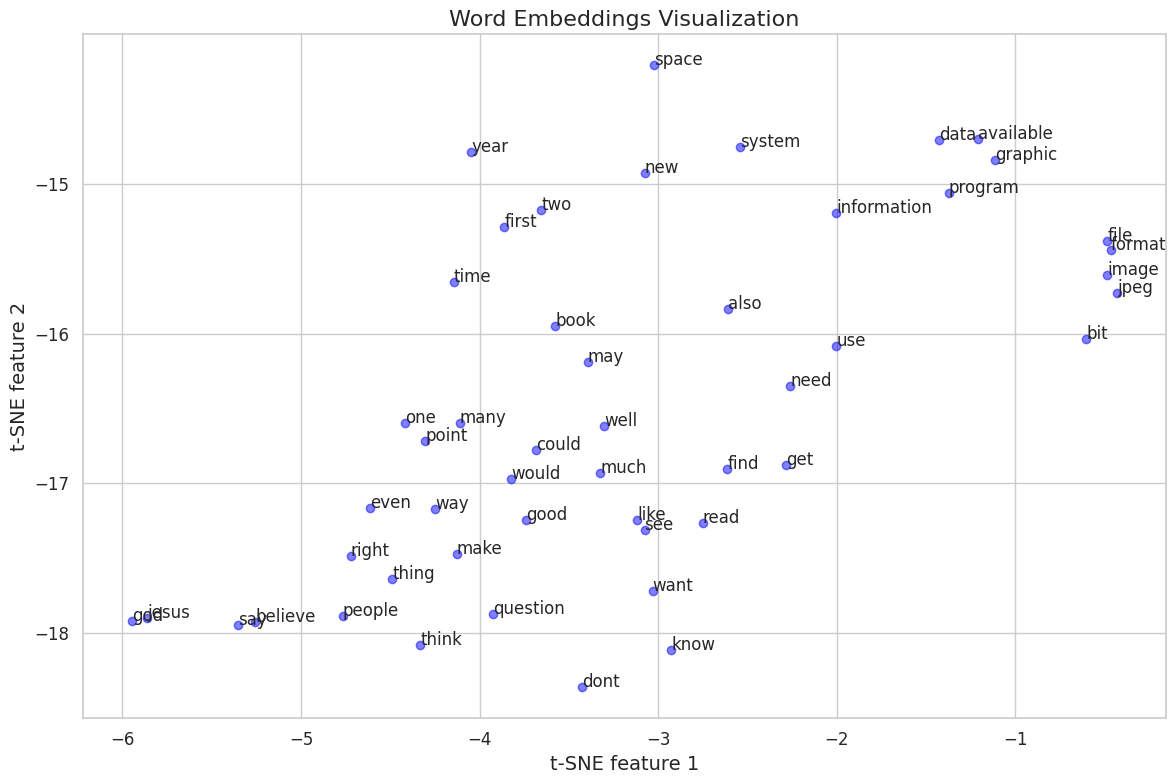

In [31]:
def create_word_embeddings(df: pd.DataFrame) -> Word2Vec:
    """
    Create word embeddings using Word2Vec.

    Args:
        df (pd.DataFrame): The dataset containing text documents.

    Returns:
        Word2Vec: Trained Word2Vec model.
    """
    # Ensure we have processed text
    if 'processed_text' not in df.columns:
        df['processed_text'] = df['text'].apply(preprocess_text)

    # Tokenize the processed text
    tokenized_texts = [text.split() for text in df['processed_text']]

    # Train Word2Vec model
    model = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=5, workers=4)
    return model

# Create word embeddings
word2vec_model = create_word_embeddings(df)

# Find similar words
print("Words similar to 'space':")
print(word2vec_model.wv.most_similar('space', topn=10))

print("\nWords similar to 'computer':")
print(word2vec_model.wv.most_similar('computer', topn=10))

# Visualize word embeddings
def plot_word_embeddings(model, words):
    """
    Plot word embeddings using t-SNE for dimensionality reduction.

    Args:
        model (Word2Vec): Trained Word2Vec model.
        words (List[str]): List of words to visualize.
    """
    # Extract word vectors
    word_vectors = np.array([model.wv[word] for word in words])

    # Reduce dimensions using t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    word_vectors_2d = tsne.fit_transform(word_vectors)

    # Plot
    plt.figure(figsize=(12, 8))
    plt.scatter(word_vectors_2d[:, 0], word_vectors_2d[:, 1], c='blue', alpha=0.5)

    for i, word in enumerate(words):
        plt.annotate(word, xy=(word_vectors_2d[i, 0], word_vectors_2d[i, 1]))

    plt.title('Word Embeddings Visualization')
    plt.xlabel('t-SNE feature 1')
    plt.ylabel('t-SNE feature 2')
    plt.tight_layout()
    plt.show()

# Select top 50 most frequent words for visualization
word_freq = {word: word2vec_model.wv.get_vecattr(word, "count") for word in word2vec_model.wv.key_to_index}
top_words = sorted(word_freq, key=word_freq.get, reverse=True)[:50]

# Plot word embeddings
plot_word_embeddings(word2vec_model, top_words)


This plot shows how words relate to each other based on how they're used in your documents. Each word is represented by a dot, and words that are close together on the plot are used in similar ways or contexts in your data.
For example, you can see 'jesus' and 'god' are very close together, which makes sense as they often appear in similar contexts. Similarly, 'file', 'image', and 'jpeg' are clustered, likely because they're often used together when discussing digital images.

This visualization helps you quickly see patterns in language use across your documents. It can reveal themes, associations, or even biases in your data that might not be obvious from reading.

The technical term for this is "word embeddings," where complex relationships between words are transformed into positions in a two-dimensional space. It's a powerful tool for analyzing large amounts of text data in a way that captures subtle patterns of language use.

### 6.4 Document Similarity

Understanding the similarity between documents can reveal how themes and topics overlap across different texts. This is useful for identifying closely related documents or clusters of documents with similar content.

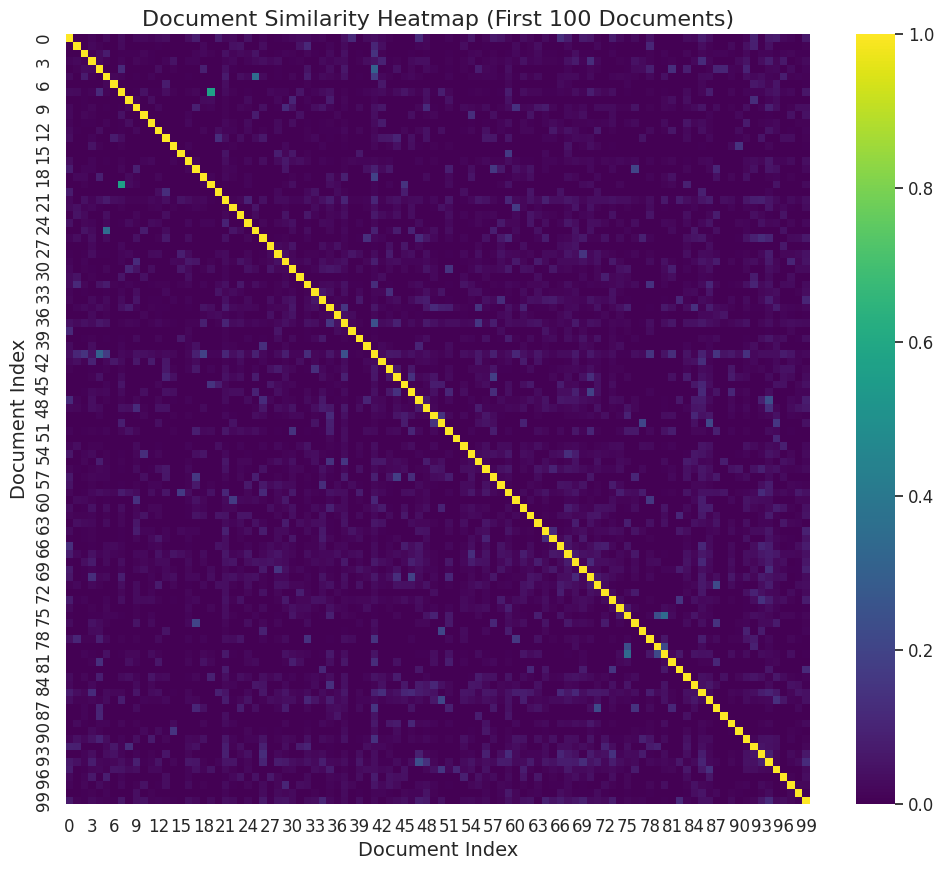

Most similar document pairs:
1. Documents 2298 and 2235: Similarity score = 1.0000
   Doc 2298:     Help!! I need code/package/whatever to take 3-D data and turn it into
a wireframe surface with h...
   Doc 2235: :     Help!! I need code/package/whatever to take 3-D data and turn it into
: a wireframe surface wi...

2. Documents 2235 and 2298: Similarity score = 1.0000
   Doc 2235: :     Help!! I need code/package/whatever to take 3-D data and turn it into
: a wireframe surface wi...
   Doc 2298:     Help!! I need code/package/whatever to take 3-D data and turn it into
a wireframe surface with h...

3. Documents 2932 and 1341: Similarity score = 1.0000
   Doc 2932: Can someone please remind me who said a well known quotation? 

He was sitting atop a rocket awaitin...
   Doc 1341: Can someone please remind me who said a well known quotation? 

He was sitting atop a rocket awaitin...

4. Documents 1773 and 3277: Similarity score = 1.0000
   Doc 1773: *************************************

In [32]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def compute_document_similarity(df: pd.DataFrame) -> np.ndarray:
    """
    Compute document similarity using TF-IDF and cosine similarity.

    Args:
        df (pd.DataFrame): The dataset containing text documents.

    Returns:
        np.ndarray: Similarity matrix for documents.
    """
    # Ensure we have processed text
    if 'processed_text' not in df.columns:
        df['processed_text'] = df['text'].apply(preprocess_text)

    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

    similarity_matrix = cosine_similarity(tfidf_matrix)
    return similarity_matrix

# Compute document similarity
similarity_matrix = compute_document_similarity(df)

# Visualize similarity matrix
plt.figure(figsize=(12, 10))
sns.heatmap(similarity_matrix[:100, :100], cmap='viridis')
plt.title('Document Similarity Heatmap (First 100 Documents)')
plt.xlabel('Document Index')
plt.ylabel('Document Index')
plt.show()

# Find most similar document pairs
def find_most_similar_pairs(similarity_matrix: np.ndarray, top_n: int = 5) -> List[Tuple[int, int, float]]:
    """
    Find the most similar document pairs.

    Args:
        similarity_matrix (np.ndarray): The document similarity matrix.
        top_n (int): Number of top pairs to return.

    Returns:
        List[Tuple[int, int, float]]: List of (doc1_index, doc2_index, similarity_score) tuples.
    """
    # Set diagonal to -1 to exclude self-similarity
    np.fill_diagonal(similarity_matrix, -1)

    # Find indices of top similar pairs
    indices = np.unravel_index(np.argsort(similarity_matrix, axis=None)[-top_n:], similarity_matrix.shape)

    # Create list of (doc1_index, doc2_index, similarity_score) tuples
    similar_pairs = [(indices[0][i], indices[1][i], similarity_matrix[indices[0][i], indices[1][i]])
                     for i in range(top_n)]

    return similar_pairs[::-1]  # Reverse to get highest similarity first

# Find and print most similar document pairs
most_similar_pairs = find_most_similar_pairs(similarity_matrix)
print("Most similar document pairs:")
for i, (doc1, doc2, score) in enumerate(most_similar_pairs, 1):
    print(f"{i}. Documents {doc1} and {doc2}: Similarity score = {score:.4f}")
    print(f"   Doc {doc1}: {df['text'].iloc[doc1][:100]}...")
    print(f"   Doc {doc2}: {df['text'].iloc[doc2][:100]}...")
    print()


This heatmap shows how similar each document is to every other document in your dataset (for the first 100 documents). It's like a visual comparison chart for your texts.

Each square represents the similarity between two documents. The brighter the color (towards yellow), the more similar the documents are. The dark purple squares show documents that are very different from each other.
The bright yellow diagonal line from top-left to bottom-right shows each document compared to itself, which is why it's the brightest (100% similar).

If you see bright squares off the diagonal, it might indicate groups of documents that are very similar – perhaps discussing the same topic or written in a similar style.

This visualization can help you spot trends, outliers, or groups in your dataset without having to read through all the documents manually. It's particularly helpful when dealing with large amounts of text data, allowing you to see relationships that might not be obvious when reading the texts one by one.

### 6.5 Named Entity Recognition

Named Entity Recognition (NER) is a technique used to identify and classify named entities in text, such as people, organizations, locations, dates, and more. This can help extract structured information from unstructured text, making it easier to analyze and understand the data.

Top entities by type:

CARDINAL:
  one: 218
  two: 162
  2: 153
  3: 144
  1: 136

WORK_OF_ART:
  Bible: 97
  Koran: 7
  Fahrenheit: 6
  Astronomy & Space: 4
  I'd Cheat on Hillary Too: 3

ORDINAL:
  first: 205
  second: 54
  First: 26
  third: 23
  Secondly: 8

DATE:
  1993: 28
  today: 25
  the day: 14
  1988: 13
  1992: 12

PERSON:
  Jesus: 221
  JPEG: 127
  Matthew: 89
  Judas: 60
  Moon: 48

ORG:
  JPEG: 240
  GIF: 177
  NASA: 111
  FTP: 99
  SGI: 82

FAC:
  Mir: 6
  Uranus: 5
  Vatican: 4
  Imagine: 4
  Massachusetts Avenue: 4

GPE:
  US: 60
  U.S.: 30
  JFIF: 30
  Simtel20: 28
  USA: 23

QUANTITY:
  10.00 pounds: 3
  10 pounds: 2
  25 to 40 feet: 2
  80 meter: 2
  70 megabyte: 2

LOC:
  Earth: 140
  Mars: 59
  Venus: 56
  Jupiter: 51
  Sun: 16

NORP:
  Christian: 74
  Christians: 52
  Christianity: 40
  Greek: 34
  Jewish: 30

PRODUCT:
  Saturn: 41
  X11: 20
  Voyager: 12
  Voyager 2: 10
  Magellan: 9

LAW:
  Constitution: 4
  ENCOURAGED: 3
  NORAD: 3
  section 7: 2
  Section 7:

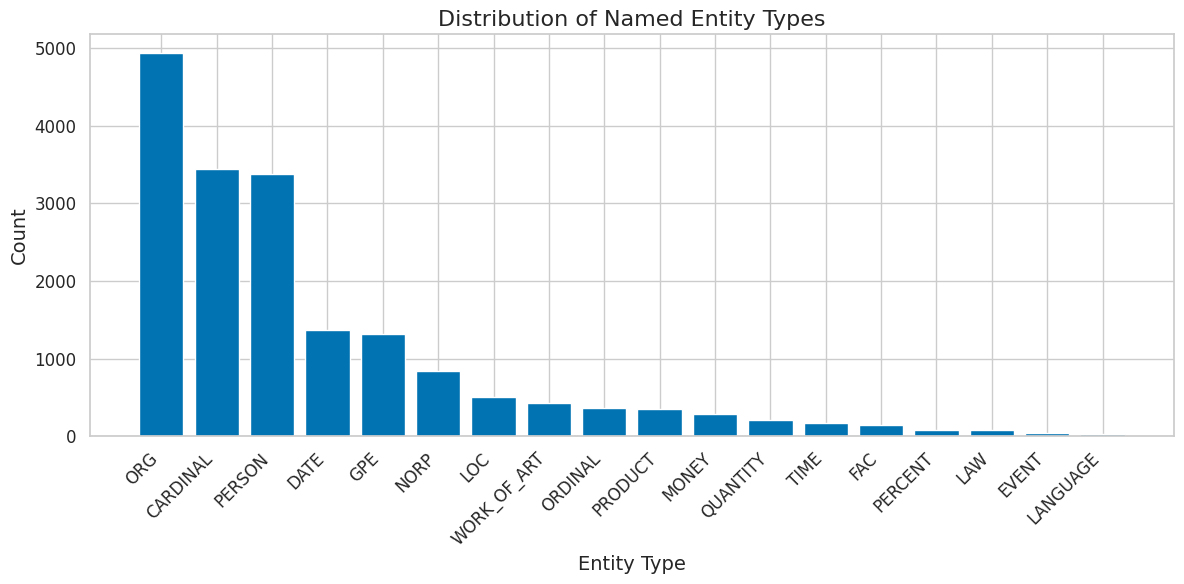

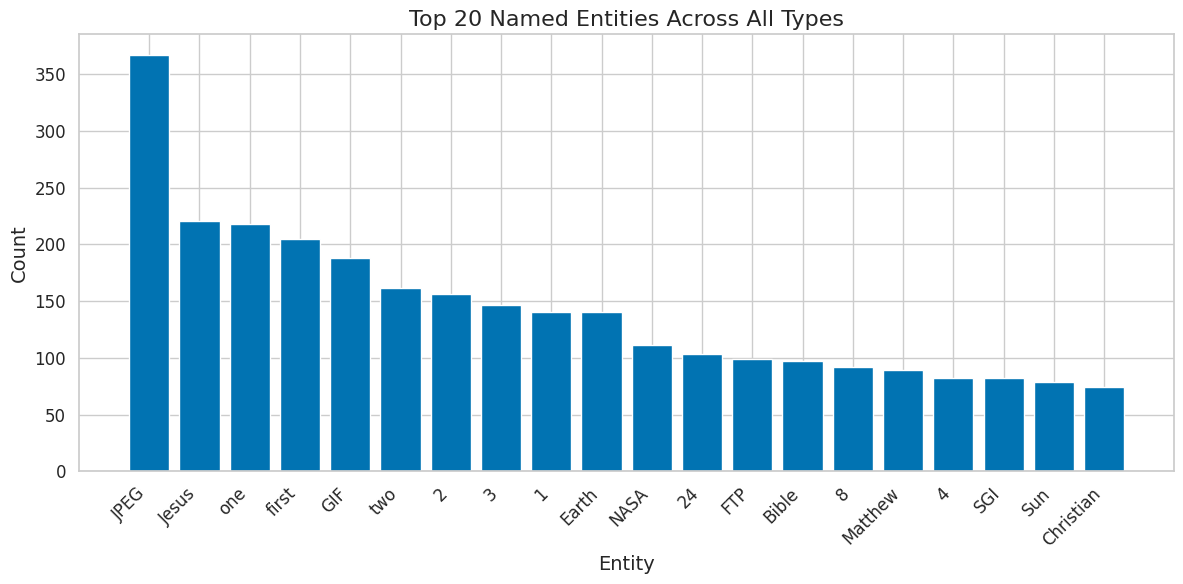

In [33]:
import spacy
from collections import Counter
import matplotlib.pyplot as plt

# Load the English NER model
nlp = spacy.load("en_core_web_sm")

def perform_ner(df: pd.DataFrame, sample_size: int = 1000) -> Dict[str, Counter]:
    """
    Perform Named Entity Recognition on a sample of documents.

    Args:
        df (pd.DataFrame): The dataset containing text documents.
        sample_size (int): Number of documents to sample for NER.

    Returns:
        Dict[str, Counter]: Dictionary of entity types and their frequency counts.
    """
    # Sample documents if the dataset is large
    if len(df) > sample_size:
        sampled_docs = df['text'].sample(n=sample_size, random_state=42)
    else:
        sampled_docs = df['text']

    entity_counts = {}
    for doc in nlp.pipe(sampled_docs, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"]):
        for ent in doc.ents:
            if ent.label_ not in entity_counts:
                entity_counts[ent.label_] = Counter()
            entity_counts[ent.label_][ent.text] += 1

    return entity_counts

# Perform NER
entity_counts = perform_ner(df)

# Print top entities for each type
print("Top entities by type:")
for entity_type, counts in entity_counts.items():
    print(f"\n{entity_type}:")
    for entity, count in counts.most_common(5):
        print(f"  {entity}: {count}")

# Visualize entity type distribution
entity_type_counts = {etype: sum(counts.values()) for etype, counts in entity_counts.items()}
sorted_types = sorted(entity_type_counts.items(), key=lambda x: x[1], reverse=True)

plt.figure(figsize=(12, 6))
plt.bar([t[0] for t in sorted_types], [t[1] for t in sorted_types])
plt.title('Distribution of Named Entity Types')
plt.xlabel('Entity Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Visualize top entities across all types
all_entities = Counter()
for counts in entity_counts.values():
    all_entities.update(counts)

top_entities = all_entities.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar([e[0] for e in top_entities], [e[1] for e in top_entities])
plt.title('Top 20 Named Entities Across All Types')
plt.xlabel('Entity')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### 6.6 Topic Network Visualization

Topic network visualization helps in understanding the relationships between topics and the words that define them. Creating a network graph helps in exploring the connections between different topics and their key terms.

Topics and their top words:
Topic 1: thanks, hacker, file, postscript, gamma, pointer, viewer, looking, tyre, format
Topic 2: kent, mary, dryden, liar, shafer, bomb, cheer, insisting, safety, live
Topic 3: vesa, driver, vpic, speedstar, compuservecom, card, truecolor, stereo, buffer, widget
Topic 4: fbi, turkey, manhattan, bobbeviceicotekcom, beauchaine, blew, bronx, sank, queen, sea
Topic 5: dont, know, like, think, god, people, space, time, image, file
Topic 6: mcwilliams, tmibmclmsuedu, tommy, hausmann, jose, maddi, radius, asimov, circumference, increase
Topic 7: element, yes, shuttle, cview, current, hijaak, fake, updated, italian, spare
Topic 8: sig, phigs, oort, detector, bcci, cloud, interstellar, parody, mom, cobb


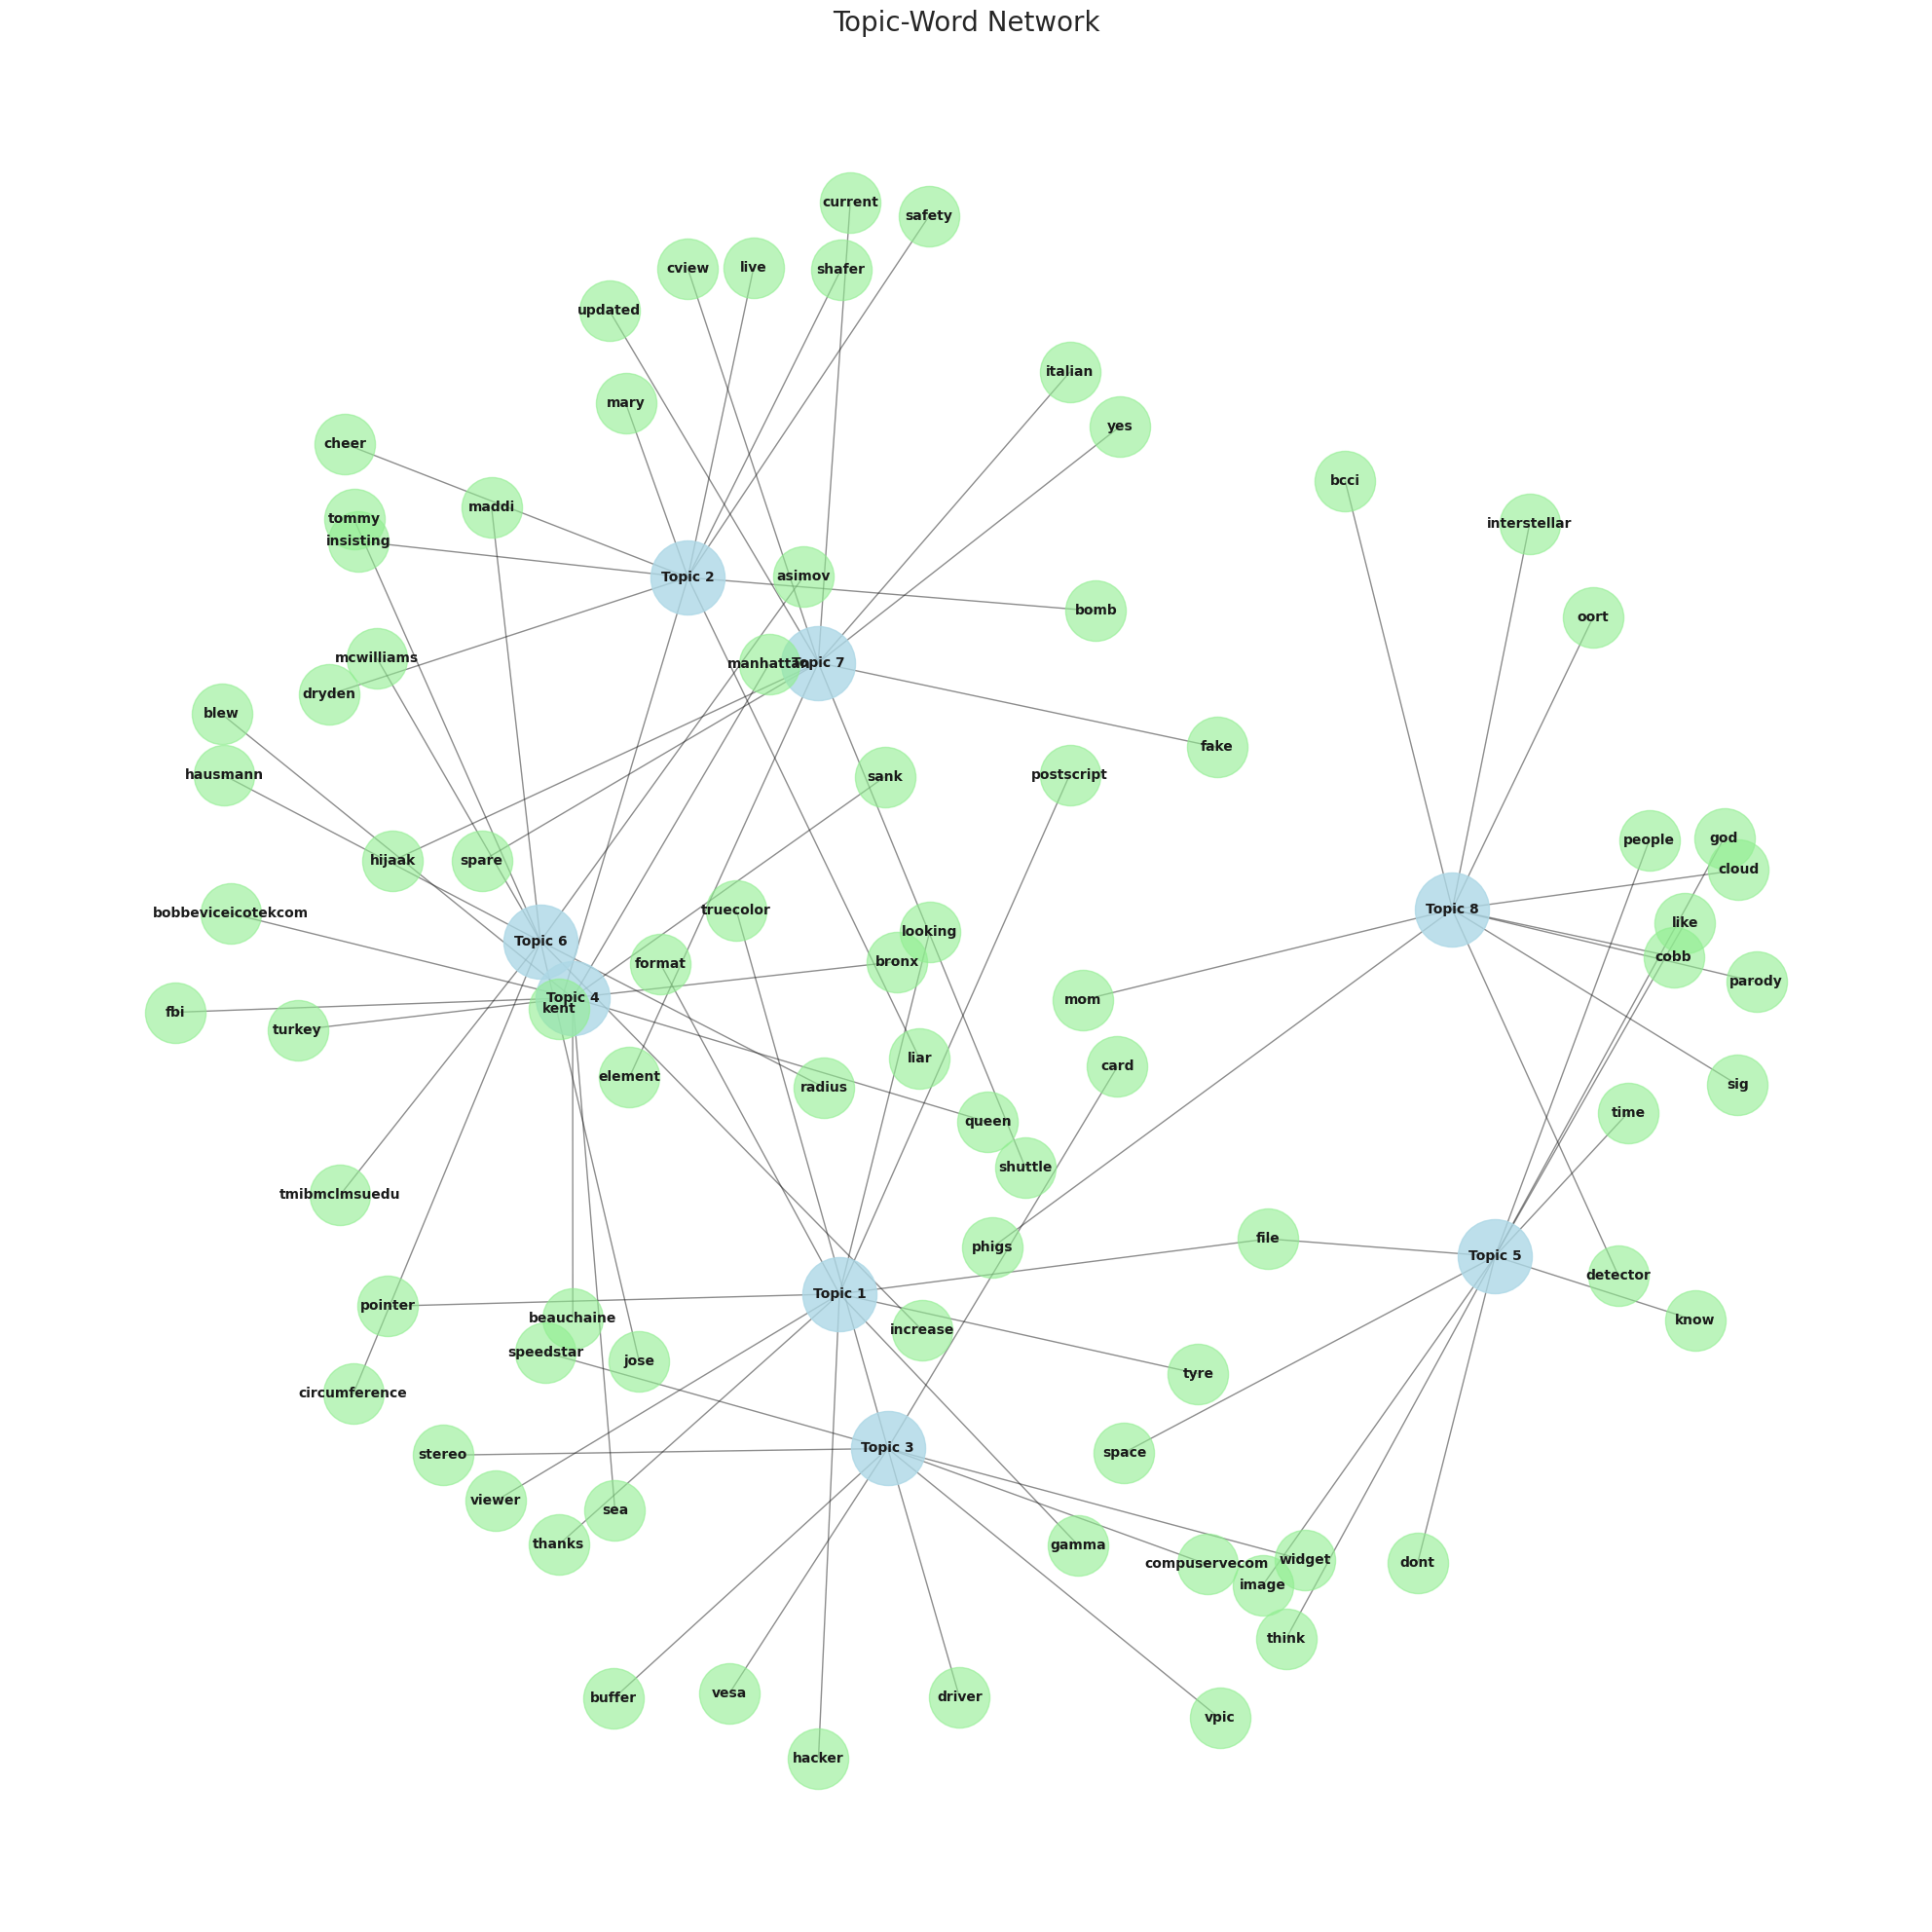

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

def perform_topic_modeling(df: pd.DataFrame, num_topics: int = 5, num_words: int = 10) -> List[List[str]]:
    """
    Perform topic modeling using Latent Dirichlet Allocation.

    Args:
        df (pd.DataFrame): The dataset containing text documents.
        num_topics (int): Number of topics to extract.
        num_words (int): Number of top words to include for each topic.

    Returns:
        List[List[str]]: A list of topics, where each topic is a list of top words.
    """
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    tfidf_matrix = vectorizer.fit_transform(df['processed_text'])

    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(tfidf_matrix)

    feature_names = vectorizer.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-num_words - 1:-1]
        top_words.append([feature_names[i] for i in top_words_idx])

    return top_words

def visualize_topic_network(topic_words: List[List[str]]):
    """
    Visualize topics as a network graph.

    Args:
        topic_words (List[List[str]]): List of top words for each topic.
    """
    G = nx.Graph()

    for i, topic in enumerate(topic_words):
        topic_node = f"Topic {i+1}"
        G.add_node(topic_node, node_type='topic')
        for word in topic:
            G.add_node(word, node_type='word')
            G.add_edge(topic_node, word)

    plt.figure(figsize=(20, 20))
    pos = nx.spring_layout(G, k=0.5, iterations=50)

    # Draw topic nodes
    topic_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'topic']
    nx.draw_networkx_nodes(G, pos, nodelist=topic_nodes, node_color='lightblue', node_size=3000, alpha=0.8)

    # Draw word nodes
    word_nodes = [node for node, data in G.nodes(data=True) if data['node_type'] == 'word']
    nx.draw_networkx_nodes(G, pos, nodelist=word_nodes, node_color='lightgreen', node_size=2000, alpha=0.6)

    # Draw edges
    nx.draw_networkx_edges(G, pos, width=1, alpha=0.5)

    # Add labels
    nx.draw_networkx_labels(G, pos, font_size=10, font_weight="bold")

    plt.title("Topic-Word Network", fontsize=20)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Perform topic modeling
top_words = perform_topic_modeling(df, num_topics=8, num_words=10)

# Print topics and their top words
print("Topics and their top words:")
for i, topic_words in enumerate(top_words):
    print(f"Topic {i+1}: {', '.join(topic_words)}")

# Visualize topic network
visualize_topic_network(top_words)


### 6.7 Sentiment Analysis

Sentiment analysis helps in understanding the emotional tone of the text, revealing whether the content is positive, negative, or neutral. This is particularly useful for gauging public opinion, track changes in sentiment over time, and identify key emotional drivers in the text data.

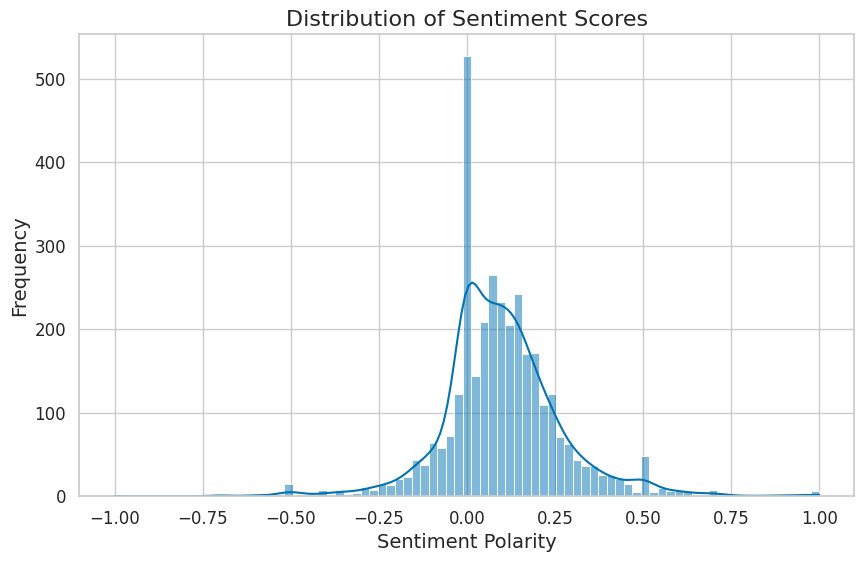

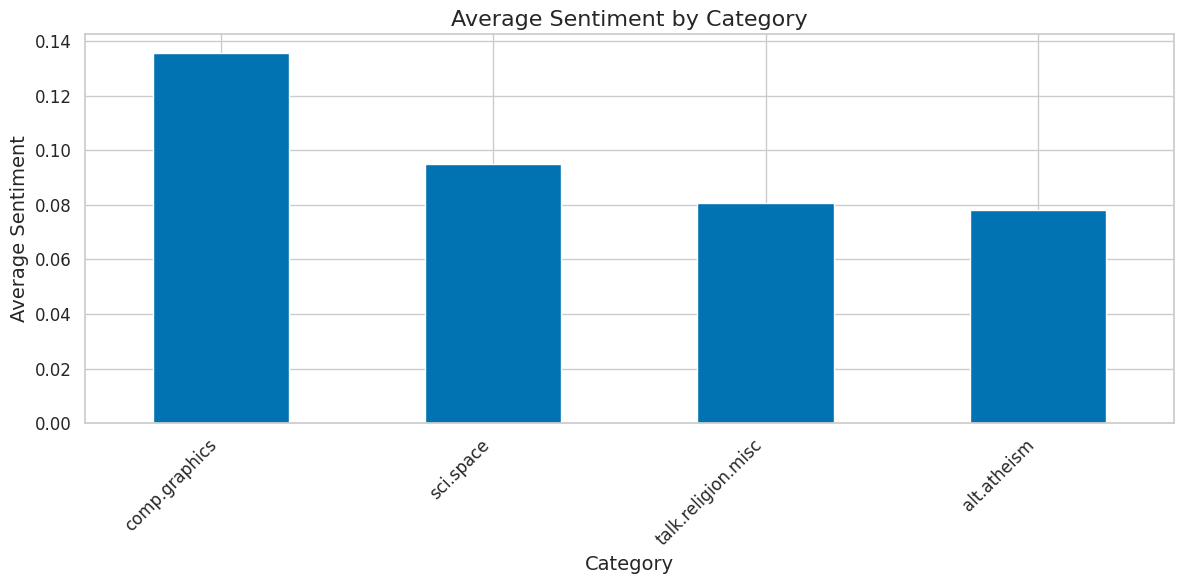

Most positive document:
Category: alt.atheism
Sentiment score: 1.0000
Text: 
Dan Johnson-

You don't know me, but take this hand anyway.  Bravo for GO(DS) = 0. 
Beautiful!  Simply beautiful!...

Most negative document:
Category: talk.religion.misc
Sentiment score: -1.0000
Text: 

That is because two creation stories is one of the worst examples of 
a difficulty with the Bible.  "were formed" can also be translated "had been
formed" in chapter two without any problems.  So the text does not demand
that there are two creation stories.  ...


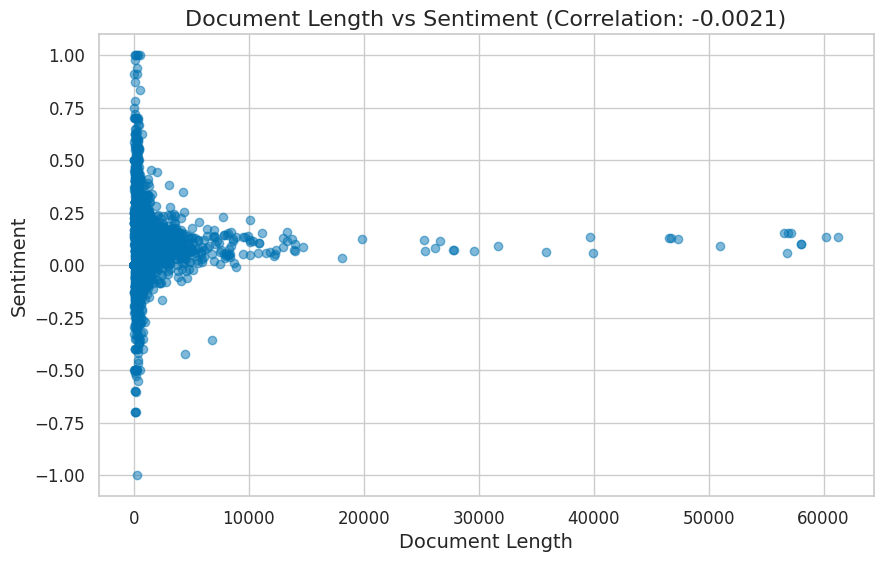

In [35]:
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns

def perform_sentiment_analysis(df: pd.DataFrame) -> pd.Series:
    """
    Perform sentiment analysis on the text documents.

    Args:
        df (pd.DataFrame): The dataset containing text documents.

    Returns:
        pd.Series: A series of sentiment polarity scores.
    """
    return df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)

# Perform sentiment analysis
df['sentiment'] = perform_sentiment_analysis(df)

# Visualize sentiment distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], kde=True)
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

# Calculate average sentiment by category
avg_sentiment = df.groupby('category')['sentiment'].mean().sort_values(ascending=False)

# Visualize average sentiment by category
plt.figure(figsize=(12, 6))
avg_sentiment.plot(kind='bar')
plt.title('Average Sentiment by Category')
plt.xlabel('Category')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Find most positive and negative documents
most_positive = df.loc[df['sentiment'].idxmax()]
most_negative = df.loc[df['sentiment'].idxmin()]

print("Most positive document:")
print(f"Category: {most_positive['category']}")
print(f"Sentiment score: {most_positive['sentiment']:.4f}")
print(f"Text: {most_positive['text'][:500]}...")

print("\nMost negative document:")
print(f"Category: {most_negative['category']}")
print(f"Sentiment score: {most_negative['sentiment']:.4f}")
print(f"Text: {most_negative['text'][:500]}...")

# Correlation between document length and sentiment
df['doc_length'] = df['text'].str.len()
correlation = df['sentiment'].corr(df['doc_length'])

plt.figure(figsize=(10, 6))
plt.scatter(df['doc_length'], df['sentiment'], alpha=0.5)
plt.title(f'Document Length vs Sentiment (Correlation: {correlation:.4f})')
plt.xlabel('Document Length')
plt.ylabel('Sentiment')
plt.show()


###6.8 Text Classification
Text classification involves categorizing text into predefined categories. This can automate tasks such as tagging documents, detecting spam, or classifying sentiment. Here is a basic implementation using a machine learning model:

In [36]:
def classify_text(df: pd.DataFrame):
    """
    Classify text documents into predefined categories using a logistic regression model.

    Args:
        df (pd.DataFrame): The dataset containing text documents and their categories.
    """
    # Preprocess text
    df['processed_text'] = df['text'].apply(preprocess_text)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df['processed_text'], df['category'], test_size=0.2, random_state=42)

    # Vectorize text data
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_test_tfidf = vectorizer.transform(X_test)

    # Train a logistic regression model
    model = LogisticRegression()
    model.fit(X_train_tfidf, y_train)

    # Predict and evaluate
    y_pred = model.predict(X_test_tfidf)
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(classification_report(y_test, y_pred))

# Perform text classification
classify_text(df)


Accuracy: 0.7729
                    precision    recall  f1-score   support

       alt.atheism       0.72      0.71      0.71       155
     comp.graphics       0.90      0.88      0.89       195
         sci.space       0.75      0.88      0.81       201
talk.religion.misc       0.67      0.52      0.59       127

          accuracy                           0.77       678
         macro avg       0.76      0.75      0.75       678
      weighted avg       0.77      0.77      0.77       678



- `Accuracy`: Overall accuracy of the model across all classes
- `precision`: Proportion of true positive predictions among all positive predictions for each class
- `recall`: Proportion of true positive predictions among all actual positive instances for each class
- `f1-score`: Harmonic mean of precision and recall for each class
- `support`: Number of instances for each class in the test set

Additional rows:
- `accuracy`: Overall accuracy (repeated from top)
- `macro avg`: Unweighted mean of metrics across all classes
- `weighted avg`: Weighted average of metrics, accounting for class imbalance

###6.9 Text Summarization
Text summarization generates a concise summary of a longer text, useful for quickly understanding large volumes of text. Here's an implementation using the gensim library:

In [37]:
from transformers import pipeline

def summarize_text(text: str, max_length: int, min_length: int, max_input_length: int = 1024) -> str:
    """
    Summarize a text document using Hugging Face Transformers.

    Args:
        text (str): The input text document.
        max_length (int): Maximum length of the summary.
        min_length (int): Minimum length of the summary.
        max_input_length (int): Maximum length of input text for the model.

    Returns:
        str: The summarized text.
    """
    summarizer = pipeline("summarization", model="sshleifer/distilbart-cnn-12-6")

    def truncate_text(text):
        """
        Truncate the input text to the maximum input length for the model.
        """
        tokenized_text = text.split()
        if len(tokenized_text) > max_input_length:
            return ' '.join(tokenized_text[:max_input_length])
        return text

    truncated_text = truncate_text(text)
    return summarizer(truncated_text, max_length=max_length, min_length=min_length, do_sample=False)[0]['summary_text']

# Select two example documents
example_texts = df['text'].iloc[:2]

# Summarize the example documents with explicit lengths
summarized_texts = example_texts.apply(lambda x: summarize_text(x, max_length=50, min_length=25))

# Display the original and summarized versions
for i, (original, summarized) in enumerate(zip(example_texts, summarized_texts)):
    print(f"Original Text {i+1}:\n{original}\n")
    print(f"Summarized Text {i+1}:\n{summarized}\n")


Original Text 1:
My point is that you set up your views as the only way to believe.  Saying 
that all eveil in this world is caused by atheism is ridiculous and 
counterproductive to dialogue in this newsgroups.  I see in your posts a 
spirit of condemnation of the atheists in this newsgroup bacause they don'
t believe exactly as you do.  If you're here to try to convert the atheists 
here, you're failing miserably.  Who wants to be in position of constantly 
defending themselves agaist insulting attacks, like you seem to like to do?!
I'm sorry you're so blind that you didn't get the messgae in the quote, 
everyone else has seemed to.

Summarized Text 1:
 You set up your views as the only way to believe, it's ridiculous and counterproductive to dialogue . I see in your posts a spirit of condemnation of the atheists in this newsgroup bacause they don't believe exactly as you do

Original Text 2:

By '8 grey level images' you mean 8 items of 1bit images?
It does work(!), but it doesn't w

###6.10 Part-of-Speech (POS) Tagging
POS tagging assigns parts of speech to each word in a text. Here's how to perform POS tagging using spaCy:

In [38]:
def pos_tagging(text: str) -> str:
    """
    Perform POS tagging on a text document.

    Args:
        text (str): The input text document.

    Returns:
        str: The text with POS tags.
    """
    doc = nlp(text)
    return ' '.join([f"{token.text}/{token.pos_}" for token in doc])

# Select two example documents
example_texts = df['text'].iloc[:2]

# Apply POS tagging to the example documents
pos_tagged_texts = example_texts.apply(pos_tagging)

# Display the original and POS-tagged versions
for i, (original, pos_tagged) in enumerate(zip(example_texts, pos_tagged_texts)):
    print(f"Original Text {i+1}:\n{original}\n")
    print(f"POS-Tagged Text {i+1}:\n{pos_tagged}\n")


Original Text 1:
My point is that you set up your views as the only way to believe.  Saying 
that all eveil in this world is caused by atheism is ridiculous and 
counterproductive to dialogue in this newsgroups.  I see in your posts a 
spirit of condemnation of the atheists in this newsgroup bacause they don'
t believe exactly as you do.  If you're here to try to convert the atheists 
here, you're failing miserably.  Who wants to be in position of constantly 
defending themselves agaist insulting attacks, like you seem to like to do?!
I'm sorry you're so blind that you didn't get the messgae in the quote, 
everyone else has seemed to.

POS-Tagged Text 1:
My/PRON point/NOUN is/AUX that/SCONJ you/PRON set/VERB up/ADP your/PRON views/NOUN as/ADP the/DET only/ADJ way/NOUN to/PART believe/VERB ./PUNCT  /SPACE Saying/VERB 
/SPACE that/SCONJ all/DET eveil/NOUN in/ADP this/DET world/NOUN is/AUX caused/VERB by/ADP atheism/NOUN is/AUX ridiculous/ADJ and/CCONJ 
/SPACE counterproductive/ADJ to/ADP

###6.11 Dependency Parsing

Dependency parsing identifies the grammatical structure of a sentence, showing the relationships between words. This is useful for deep linguistic analysis and understanding complex sentence structures.

In [39]:
def dependency_parsing(text: str):
    """
    Perform dependency parsing on a text document.

    Args:
        text (str): The input text document.
    """
    doc = nlp(text)
    for token in doc:
        print(f"{token.text} ({token.dep_}) --> {token.head.text}")

# Select an example document
example_text = df['text'].iloc[0]

# Apply dependency parsing to the example document
print(f"Original Text:\n{example_text}\n")
print("Dependency Parsing:")
dependency_parsing(example_text)


Original Text:
My point is that you set up your views as the only way to believe.  Saying 
that all eveil in this world is caused by atheism is ridiculous and 
counterproductive to dialogue in this newsgroups.  I see in your posts a 
spirit of condemnation of the atheists in this newsgroup bacause they don'
t believe exactly as you do.  If you're here to try to convert the atheists 
here, you're failing miserably.  Who wants to be in position of constantly 
defending themselves agaist insulting attacks, like you seem to like to do?!
I'm sorry you're so blind that you didn't get the messgae in the quote, 
everyone else has seemed to.

Dependency Parsing:
My (poss) --> point
point (nsubj) --> is
is (ROOT) --> is
that (mark) --> set
you (nsubj) --> set
set (ccomp) --> is
up (prt) --> set
your (poss) --> views
views (dobj) --> set
as (prep) --> set
the (det) --> way
only (amod) --> way
way (pobj) --> as
to (aux) --> believe
believe (relcl) --> way
. (punct) --> is
  (dep) --> .
Saying (csu

### 6.12 Topic Coherence

Topic coherence measures how coherent or meaningful the topics generated by topic modeling are. This helps in evaluating the quality of the topics and selecting the best number of topics.

In [42]:
def preprocess_text(text: str) -> List[str]:
    """
    Preprocess the input text.
    """
    return ''.join([char.lower() if char.isalnum() else ' ' for char in text]).split()

def perform_topic_modeling(X, vectorizer, num_topics):
    """
    Perform topic modeling using Latent Dirichlet Allocation.
    """
    lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
    lda.fit(X)

    feature_names = vectorizer.get_feature_names_out()
    top_words = []
    for topic_idx, topic in enumerate(lda.components_):
        top_words_idx = topic.argsort()[:-10 - 1:-1]
        top_words.append([feature_names[i] for i in top_words_idx])

    return top_words

def calculate_topic_coherence(topics: List[List[str]], texts: List[str]) -> List[float]:
    """
    Calculate topic coherence for each topic.
    """
    preprocessed_texts = [preprocess_text(text) for text in texts]
    dictionary = Dictionary(preprocessed_texts)
    topics_ids = [[dictionary.token2id[word] for word in topic if word in dictionary.token2id] for topic in topics]
    topics_ids = [topic for topic in topics_ids if topic]

    if not topics_ids:
        raise ValueError("No valid topics found after filtering. Check if your topic words are present in the texts.")

    coherence_scores = []
    for topic in topics_ids:
        coherence_model = CoherenceModel(topics=[topic], texts=preprocessed_texts, dictionary=dictionary, coherence='c_v')
        coherence_scores.append(coherence_model.get_coherence())

    return coherence_scores

sample_size = min(1000, len(df))
sample_texts = df['text'].sample(n=sample_size, random_state=42).tolist()

vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(sample_texts)

num_topics = 10
top_words = perform_topic_modeling(X, vectorizer, num_topics)

coherence_scores = calculate_topic_coherence(top_words, sample_texts)

for i, (topic_words, coherence) in enumerate(zip(top_words, coherence_scores), 1):
    print(f"Topic {i}: {', '.join(topic_words)}")
    print(f"Coherence Score: {coherence:.4f}\n")

overall_coherence = sum(coherence_scores) / len(coherence_scores)
print(f"Overall Topic Coherence Score: {overall_coherence:.4f}")

Topic 1: space, like, know, just, book, don, time, question, think, books
Coherence Score: 0.4072

Topic 2: jesus, matthew, prophecy, time, law, course, said, messiah, david, king
Coherence Score: 0.6164

Topic 3: god, people, don, think, just, does, say, know, believe, jesus
Coherence Score: 0.6186

Topic 4: jpeg, image, gif, file, images, color, format, files, bit, quality
Coherence Score: 0.8418

Topic 5: edu, graphics, data, ftp, available, pub, image, mail, software, send
Coherence Score: 0.7261

Topic 6: graphics, think, war, say, rw, computer, file, sure, like, know
Coherence Score: 0.2251

Topic 7: image, program, gamma, display, file, read, bits, video, card, 24
Coherence Score: 0.5287

Topic 8: space, nasa, dc, larson, orbit, edu, launch, faq, earth, time
Coherence Score: 0.4322

Topic 9: space, does, new, word, cview, greek, 10, ve, jim, just
Coherence Score: 0.2473

Topic 10: earth, planet, solar, spacecraft, moon, surface, mars, space, venus, atmosphere
Coherence Score: 0.

# 7. Conclusion and Next Steps

We've covered a range of methods from basic text processing to advanced natural language understanding tasks, demonstrating how these techniques can be applied to real-world data from the 20 Newsgroups dataset.

## Key Takeaways

1. AI techniques can provide deep initial insights into textual data. Different methods serve various purposes: from understanding broad themes (topic modeling) to analyzing sentiment and identifying named entities:

  1.1 Topic Modeling: Latent Dirichlet Allocation (LDA) can uncover hidden thematic structures in large text corpora, helping identify main discussion themes across newsgroups.

  1.2 Text Clustering: K-means clustering on TF-IDF vectors can group similar documents, revealing patterns in how different topics are discussed across categories.
  
  1.3 Word Embeddings: Techniques like Word2Vec capture semantic relationships between words, allowing for nuanced analysis of language use in different contexts.

  1.4 Document Similarity: Cosine similarity on TF-IDF vectors can identify closely related documents, useful for understanding how discussions evolve or relate across newsgroups.

  1.5 Named Entity Recognition (NER): Identifying and classifying named entities (e.g., persons, organizations, locations) can provide insights into the key actors and subjects discussed in different newsgroups.

  1.6 Topic Network Visualization: Visualizing relationships between topics and words can reveal complex interconnections in discussions across newsgroups.

  1.7 Sentiment Analysis: Analyzing the emotional tone of texts can help understand attitudes and opinions expressed in different newsgroups or on different topics.

  1.8 Text Classification: Machine learning models can automatically categorize texts, potentially identifying misclassified posts or emerging sub-categories.

  1.9 Part-of-Speech (POS) Tagging: Analyzing the grammatical structure of texts can reveal linguistic patterns characteristic of different newsgroups or topics.

  1.10 Topic Coherence: Evaluating the quality of extracted topics ensures that our topic models are producing meaningful and interpretable results.

2. One must preprocess text data appropriately before applying these techniques.
3. Visualization greatly improves interpretation of data.